
# Multimodal Flow Tutorial: 8 Gaussians → Two Moons with colors!

This notebook demonstrates training a simple multimodal flow (continuous + discrete) to map colored points between source and target data. Specifically:
- Continuous modality: the $(x,y)$ coordinates in the 2D plane. We use conditional flow-matching with uniform dynamics to flow beteen positions. 
- Discrete modality: a categorical label `1..S` for S discrete colors. We use the Random Telegraph bridge to jump betwen colors.




## Data Generation

We synthesize two toy datasets with 80K points and $S=8$ possible colors:
- `NGaussians`: 8 Gaussian blobs in 2D (source) with 8 colors for each component.
- `TwoMoons`: classic two‑moons in 2D (target) with 2 colors for each disconeceted component.

Both datasets return:
- continuous: `(B, 2)`
- discrete tokens: `(B, 1)` with a vocabuilary size of `S=8` 


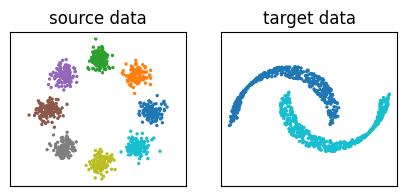

In [4]:
import torch
import matplotlib.pyplot as plt
from utils.toy_data import NGaussians, TwoMoons

gaussians = NGaussians(num_gaussians=8,
                       num_points_per_gaussian=10000,
                       std_dev=0.1,
                       scale=5)

moons = TwoMoons(num_points_per_moon=40000, std_dev=0.2)


# plot source and target data

_, ax = plt.subplots(1, 2, figsize=(5, 2))

gaussians.display(num_points=1000, s=2, cmap="tab10", alpha=1, ax=ax[0], label="target")
moons.display(num_points=1000, s=2, cmap="tab10", alpha=1, ax=ax[1], label="source")

ax[0].set_title('source data')
ax[1].set_title('target data')
plt.show()


## Data Coupling and Loader

We wrap the source/target tensors into `TensorMultiModal` objects and pair them with `DataCoupling`. The `MultiModalDataset` and a `DataLoader` provide batched batches for training and prediction.


In [5]:
import torch
from torch.utils.data import DataLoader
from utils.datasets import MultiModalDataset, DataCoupling, data_coupling_collate_fn
from utils.tensorclass import TensorMultiModal

eight_gauss = TensorMultiModal(continuous=gaussians.continuous, 
                               discrete=gaussians.discrete, 
                               mask=torch.ones_like(gaussians.discrete))
                               
two_moons = TensorMultiModal(continuous=moons.continuous, 
                             discrete=moons.discrete, 
                             mask=torch.ones_like(moons.discrete))

data = DataCoupling(source=eight_gauss, target=two_moons)
dataset = MultiModalDataset(data)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=data_coupling_collate_fn)

## Conditional Dynamics: Uniform Flow (continuous) and Random Telegraph Bridge (discrete)

- `UniformFlow(sigma)`: samples intermediate continuous states via linear interpolation with Gaussian smear; drift is `x1 - x0`.
- `RandomTelegraphBridge(beta, vocab_size)`: samples intermediate discrete tokens and provides jump rates. It expects `(B,1)` tokens in `1..S` and returns probabilities over `S` classes.


In [ ]:

import torch
from torch.distributions import Categorical

class UniformFlow:
    def __init__(self, sigma):
        self.sigma = sigma

    def sample(self, time: torch.Tensor, batch) -> torch.Tensor:
        # continuous shapes: (B, dim); time in (B,)
        t = time.view(-1, 1)
        x0 = batch.source.continuous  # (B, dim)
        x1 = batch.target.continuous  # (B, dim)
        xt = t * x1 + (1.0 - t) * x0
        xt = xt + self.sigma * torch.randn_like(xt)
        return xt

    def conditional_drift(self, state, batch) -> torch.Tensor:
        # drift = x1 - x0 ; shapes (B, dim)
        return batch.target.continuous - batch.source.continuous

class RandomTelegraphBridge:
    """Random Telegraph bridge for discrete labels with tokens 1..S.
    Shapes: discrete (B,1), probs (B,S), time (B,).
    """
    def __init__(self, beta, vocab_size):
        self.beta = beta
        self.vocab_size = vocab_size

    def sample(self, time: torch.Tensor, batch) -> torch.Tensor:
        k0 = batch.source.discrete.view(-1)                 # (B,)
        k1 = batch.target.discrete.view(-1)                 # (B,)
        probs = self.transition_probability(time, k0, k1)   # (B,S)
        kt = Categorical(probs).sample()                    # (B,) in [0..S-1]
        return (kt + 1).unsqueeze(-1)                       # map back to tokens 1..S and add dim

    def rate(self, state, probs: torch.Tensor) -> torch.Tensor:
        t = state.time                                      # (B,)
        k = state.discrete.view(-1).long()                  # (B,)
        S = self.vocab_size
        qx = probs                                          # (B,S)
        idx = (k - 1).clamp(min=0, max=S-1).view(-1, 1)     # 0-based indices
        qy = torch.gather(qx, 1, idx)                       # (B,1)
        wt = self.omega_t(t, torch.ones_like(t))            # (B,)
        A, B, C = 1.0, (wt * S) / (1.0 - wt), wt
        return A + B[:, None] * qx + C[:, None] * qy        # (B,S)
        
    def transition_probability(self, t: torch.Tensor, k0: torch.Tensor, k1: torch.Tensor) -> torch.Tensor:
        # Returns probs over classes 1..S for each element; k0,k1 shapes (B,)
        device = k0.device
        B = k0.shape[0]
        S = self.vocab_size
        k = torch.arange(1, S + 1, device=device).view(1, S).expand(B, S)  # (B,S)

        p_k_to_k1 = self.conditional_probability(t, torch.ones_like(t), k, k1.view(-1, 1).expand_as(k))  # (B,S)
        p_k0_to_k = self.conditional_probability(torch.zeros_like(t), t, k0.view(-1, 1).expand_as(k), k)  # (B,S)
        p_k0_to_k1 = self.conditional_probability(torch.zeros_like(t), torch.ones_like(t), k0, k1)  # (B,)
        return (p_k_to_k1 * p_k0_to_k) / p_k0_to_k1.view(-1, 1)

    def conditional_probability(self, t_in, t_out, k_in: torch.Tensor, k_out: torch.Tensor) -> torch.Tensor:
        # k_in,k_out: (B,S) or (B,)
        if isinstance(t_in, (float, int)):
            t_in = torch.full((k_out.shape[0],), float(t_in), device=k_out.device)
        if isinstance(t_out, (float, int)):
            t_out = torch.full((k_out.shape[0],), float(t_out), device=k_out.device)

        wt = self.omega_t(t_in, t_out)  # (B,)
        S = self.vocab_size
        delta = (k_out == k_in).float()

        if k_out.ndim == 1:
            return 1.0 / S + wt * (delta - 1.0 / S)
        else:
            return 1.0 / S + wt[:, None] * (delta - 1.0 / S)

    def omega_t(self, t_in: torch.Tensor, t_out: torch.Tensor) -> torch.Tensor:
        # constant beta_t scheduler
        return torch.exp(-self.vocab_size * self.beta * (t_out - t_in))


## MultiModal Flow (MMF) model

Pytorch Lightning implementation of a minimal MLP architecture $u_t^\theta\otimes h_t^\theta$ with:
- Time embedding: Fourier features
- Continuous and discrete embeddings are added and passed through a 3-layered MLP with GELU activations,
- Regressor head $u_t^\theta$ for MSE loss and posterior classifier head $h_t^\theta$ for the CE loss

Additive loss:
$\mathcal{L}=\mathcal{L}_{MSE} + \mathcal{L}_{CE}$ 

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as L
from torch.nn import functional as F
from typing import Tuple

from utils.tensorclass import TensorMultiModal
from utils.datasets import DataCoupling
from utils.models import TimeFourierEmbedding

class MultiModalFlow(L.LightningModule):

    """ Hybrid Dynamical generative model for continuous and discrete states
        based on continuous-time Markov jump processes and flow matching.
    """    
    def __init__(self, 
                 sigma, 
                 beta, 
                 vocab_size, 
                 n_embd=64,
                 lr=0.001,
                 num_steps=100):

        super().__init__()

        # bridge dynamics:
        self.bridge_continuous = UniformFlow(sigma)
        self.bridge_discrete = RandomTelegraphBridge(beta, vocab_size)

        # neural network approximating the dynamics generators
        self.model = nn.ModuleDict(dict(wt=TimeFourierEmbedding(n_embd),
                                        wx=nn.Linear(2, n_embd),
                                        wk=nn.Embedding(vocab_size + 1, n_embd, padding_idx=0),
                                        mlp=nn.Sequential(nn.Linear(n_embd, n_embd),
                                                          nn.GELU(),
                                                          nn.Linear(n_embd, n_embd),
                                                          nn.GELU(),
                                                          nn.Linear(n_embd, n_embd)
                                                          ),
                                        reg_head=nn.Linear(n_embd // 2, 2),
                                        class_head=nn.Linear(n_embd // 2, vocab_size)
                                     ))
        self.n_embd = n_embd
        self.vocab_size = vocab_size
        self.num_steps = num_steps
        self.lr = lr

    # ...Lightning methods 

    def forward(self, state: TensorMultiModal) -> (torch.Tensor, torch.Tensor):
        t_emb = self.model.wt(state.time)
        x_emb = self.model.wx(state.continuous)
        k_emb = self.model.wk(state.discrete.long().squeeze(-1))
        h = self.model.mlp(x_emb + k_emb + t_emb)
        h1, h2 = h.split((self.n_embd // 2, self.n_embd // 2), dim=-1) 
        ut = self.model.reg_head(h1)
        ht = self.model.class_head(h2)
        return ut, ht

    def training_step(self, batch: DataCoupling, batch_idx):
        loss = self.multimodal_loss(batch)
        return {"loss": loss}

    def predict_step(self, batch: DataCoupling, batch_idx, dataloader_idx=0) -> TensorMultiModal:
        ''' for sample generation
        '''
        trajectories = self.simulate_dynamics(batch)
        return trajectories.detach().cpu()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    # ...Model functions

    def multimodal_loss(self, batch: DataCoupling) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """ Markov bridge CE loss + Flow-matching MSE loss for shapes:
            continuous (B, dim), discrete (B,) with tokens 1...S, S=vocab_size
        """
        batch.source = batch.source.to(self.device)
        batch.target = batch.target.to(self.device)
        time =  torch.rand(len(batch), device=self.device)  # (B,)

        # sample intermediate states
        xt = self.bridge_continuous.sample(time, batch)   # (B, dim)
        kt = self.bridge_discrete.sample(time, batch)     # (B,1) tokens 1...S
        state = TensorMultiModal(continuous=xt, discrete=kt, time=time).to(self.device)
        ut, ht = self.forward(state)   # (B, dim), (B, S)

        #  MSE for continuous states
        targets_continuous = self.bridge_continuous.conditional_drift(state, batch)  # (B, dim)
        loss_mse = F.mse_loss(ut, targets_continuous, reduction="mean")

        # CE for discrete states
        targets_discrete = (batch.target.discrete.view(-1) - 1).clamp(min=0).long().to(self.device)
        loss_ce = F.cross_entropy(ht, targets_discrete, reduction="mean")

        return loss_mse + loss_ce

    
    @torch.no_grad()
    def simulate_dynamics(self, batch: DataCoupling) -> TensorMultiModal:
            """ generate target data from source input using trained dynamics
                returns the final state of the bridge at the end of the time interval
            """
            self.eval()
            device = self.device
            time_steps = torch.linspace(0.0, 1.0, self.num_steps, device=device)
            delta_t = (time_steps[-1] - time_steps[0]) / (len(time_steps) - 1)
            state = batch.source.clone().to(device)
            paths = [state.clone()]  # append t=0 source

            S = self.vocab_size

            for t in time_steps:

                state.time = torch.full((len(state),), t.item(), device=device)
                ut, ht = self.forward(state)
                probs = F.softmax(ht, dim=-1)   
                rates = self.bridge_discrete.rate(state, probs)  # (B, S)

                # tau-leaping step (discrete)
                k_idx = (state.discrete.view(-1) - 1).long()                # (B,) in 0..S-1
                delta_n = torch.poisson(rates * delta_t)                    # (B,S)
                total_jumps = delta_n.sum(dim=-1)
                jump_mask = (total_jumps <= 1).to(k_idx.dtype)              # allow at most one jump:
                class_idx = torch.arange(S, device=device).view(1, S)
                diff = class_idx - k_idx.unsqueeze(-1)                      # (B,S)
                net_jumps = (delta_n * diff).sum(dim=-1).to(k_idx.dtype)    # (B,)
                k_idx = (k_idx + net_jumps * jump_mask) % S
                state.discrete = (k_idx + 1).unsqueeze(-1)                  # back to 1..S, shape (B,1)

                # euler step (continuous)
                state.continuous = state.continuous + ut * delta_t 

                paths.append(state.clone())

            paths = TensorMultiModal.stack(paths, dim=0)
            return paths



## Training

We use PyTorch Lightning’s `Trainer` to optimize the model. 
The dataloader yields batches of `(source, target)` pairs

In [8]:
import pytorch_lightning as L

epochs = 20
sigma = 0.1
beta = 0.25
vocab_size = 8
n_embd = 128
lr = 1e-3

mmf = MultiModalFlow(sigma=sigma, beta=beta, vocab_size=vocab_size, n_embd=n_embd, lr=lr)
trainer = L.Trainer(max_epochs=epochs, accelerator='gpu', devices=[0])
trainer.fit(mmf, dataloader)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | ModuleDict | 51.7 K | train
---------------------------------------------
51.7 K    Trainable params
0         Non-trainable params
51.7 K    Total params
0.207     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
/home/df630/.conda/envs/multiflows/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


# 2 moons Generation

we sample a new 8 gaussian source as an initial condition (t=0) and solve the hybrid dynamics until t=1 to get the generated samples, 

In [ ]:
source_gauss = NGaussians(num_gaussians=8,
                          num_points_per_gaussian=1000,
                          std_dev=0.1,
                          scale=5)

input_source = TensorMultiModal(continuous=source_gauss.continuous, 
                              discrete=source_gauss.discrete, 
                              mask=torch.ones_like(source_gauss.discrete))
                              
empty_target = TensorMultiModal() # dummy target 

source_data = DataCoupling(source=input_source, target=empty_target)
gen_dataset = MultiModalDataset(source_data)
gen_dataloader = DataLoader(gen_dataset, batch_size=256, shuffle=True, collate_fn=data_coupling_collate_fn)


/tmp/ipykernel_683794/3281643919.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  points += np.array([center_x, center_y]) * self.scale
/tmp/ipykernel_683794/3281643919.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return positions, torch.tensor(labels, dtype=torch.long)


we use the `predict` method to simmulate the generative dynamics trajectories/jumps

In [ ]:
sample_batched = trainer.predict(mmf, dataloader)
sample = TensorMultiModal.cat(sample_batched, dim=1)   # concat generated batches

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/multiflows/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/df630/.conda/envs/multiflows/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

#

/tmp/ipykernel_689129/1887965429.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax[j].scatter(paths[0, :N, 0], paths[0, :N, 1], s=1, color='gray', alpha=0.2, vmin=vmin, vmax=vmax)


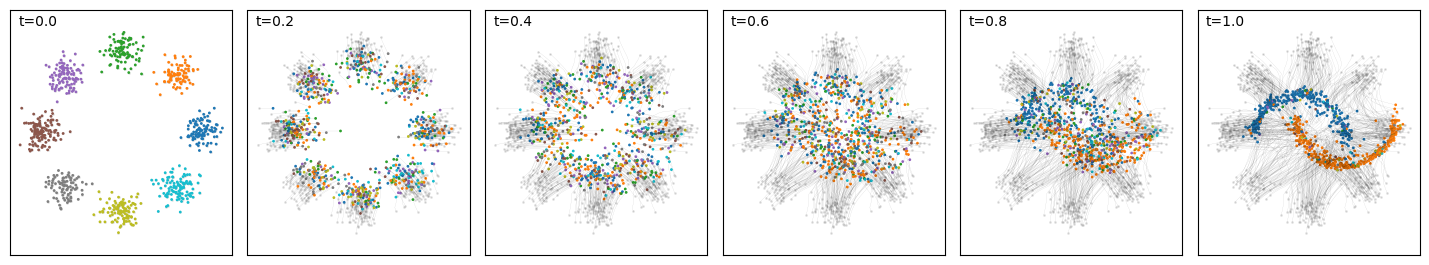

In [ ]:
from utils.plotting import plot_trajectories

plot_trajectories(sample, N=800)